In [1]:
import torch
from torch import nn
import torch.optim as optim
from fastai.vision.all import *
import matplotlib.pyplot as plt
from models_module import my_models
from train_module import training_functions
import matplotlib.pyplot as plt

GRAPH_PATH = "./data/graphs/"

In [2]:
in_channels = 3
out_channels = 3
device = "cuda:2"
net = my_models.UNet(in_channels = in_channels, 
            out_channels = out_channels)
net.to(device)

train_loss = nn.MSELoss()

learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

batch_size = 50
epoch_num = 20

In [3]:
path = URLs.IMAGENETTE_160

In [4]:
trainloader, valloader = training_functions.prepare_train_and_val_dls(path, batch_size, size=160, num_workers=4)

In [5]:
def calculate_loss(dataloader, net, device, criterion):
    """Loss for network inference.
    
    """
    current_loss = 0.0
    steps = 0
    
    for data in dataloader:
        with torch.no_grad():
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)         
            loss = criterion(outputs, inputs)
            current_loss += loss.cpu().numpy()
            steps += 1

    current_loss /= steps
    return current_loss


In [6]:
def train(net, optimizer, criterion, epoch_num, trainloader, valloader, device, graph_path):
    """Neural network training process.
    
    """
    val_loss_history = []
    train_loss_history = []
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        for data in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
          
        
        # Train accuracy and loss
        current_train_loss = calculate_loss(trainloader, net, device, criterion)     
        train_loss_history.append(current_train_loss)

        # Validation accuracy and loss
        current_val_loss = calculate_loss(valloader, net, device, criterion)     
        val_loss_history.append(current_val_loss)
        
        # visulization:
        if (epoch+1)%5 == 0:
            plt.figure(figsize=(10,7))
            plt.plot(train_loss_history, label=f'Train loss') 
            plt.plot(val_loss_history, label=f'Validation loss') 
            plt.title("Losses")
            plt.xlabel("Epoch number")
            plt.ylabel("Loss")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(graph_path)
            
    return net, {"val losses": val_loss_history, 
                 "train losses": train_loss_history}

CPU times: user 4min 6s, sys: 2min 21s, total: 6min 27s
Wall time: 6min 58s


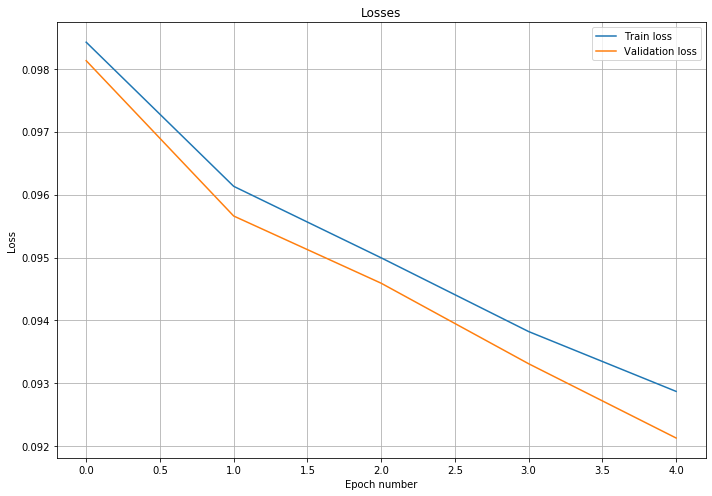

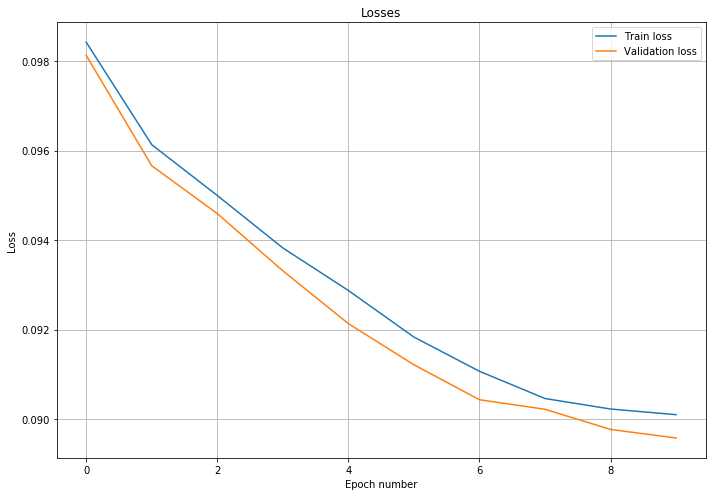

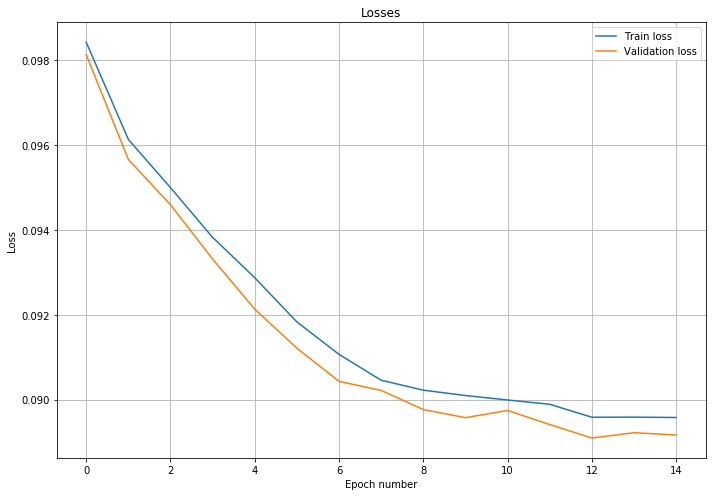

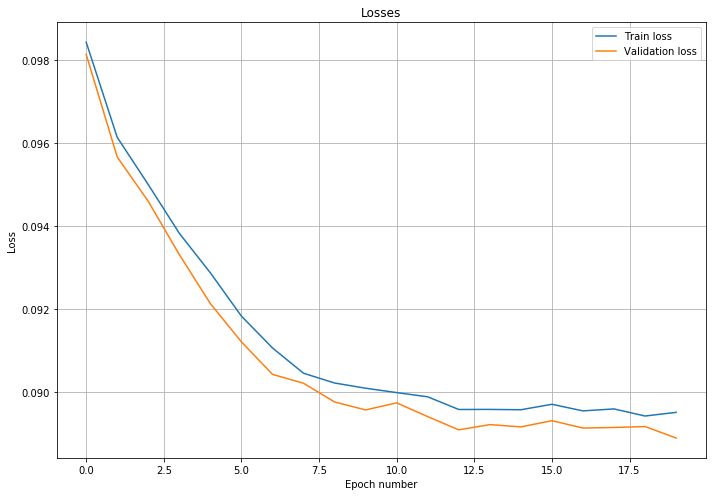

In [7]:
%%time
net, optimization_history = train(net, optimizer, train_loss, epoch_num,
                                  trainloader, valloader, device, GRAPH_PATH+"unet_train_info.jpg")

In [8]:
data, labels = valloader.one_batch()

In [9]:
outputs = net(data.to(device))

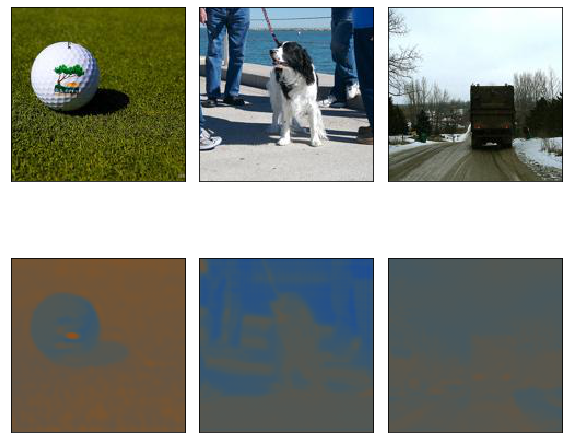

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(data[picture_num].cpu().permute(1, 2, 0))
    else:
        ax.imshow(outputs[picture_num-3].detach().cpu().permute(1, 2, 0))


plt.tight_layout()
plt.show()